# Reinforced Learning - Temporal Difference
### Josh Mau

## Overview
In this notebook I have implemented the Temporal Difference method for reinforced learning. This algorithm was used to teach the program how to solve the Towers of Hanoi puzzel. 

## Description of the puzzle
In towers of hanoi, there are 3 "towers" or pegs which can contain discs. The puzzle start state is with all three discs on the far left tower. While the playing the game, no disc of a large size can be placed on top of a smaller disc and only one disc can be moved at a time. The goal state is a mirror image of the start state except all discs are on the third pegs
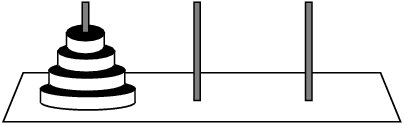

                        (this image from: http://mathworld.wolfram.com/TowerofHanoi.html)
                        
There is no real limit to the number of discs that can be used, but the minimum solutions is 2^(number of discs) -1 as can be seen below in the examples, using 3 discs, 2^3 -1 = 7 which is what the program converges on.

## Implementation
The follow code contains implementations for the following methods:
* `printState(state)`: Used as a visual description of the current state of the puzzel
* `validMoves(state)`: Returns list of all valid moves. These lists are of length 2, the 0 index is which tower to move the top element of, and the 1st index is which tower to move to. This method contains error checking when trying to move a disc of larger size onto a disc of a smaller size, and when trying to move a disc to a "full" tower (ideally should never occur)
* `makeMove(state, move)`: This method executes a move on the current state of the puzzel and returns the new state
* `trainQ(nRepetitions, learningRate, epsilonDecayFactor, validMovesF, makeMoveF)`: This function trains the computer on playing Towers of Hanoi. Parameters include
    * **nRepetitions**: How many repititions the algorithm should run to find the best Q
    * **learningRate**: How fast the machine will learn
    * **epsilonDecayFactor**: How fast epsilon will decay - if too small, not enough moves will be explored
    
* `epsilonGreedy(epsilon, Q, state)`: Determines whether a random move will be made, or the smallest Q move. As epsilon decays, less random moves will be taken and more greedy moves will be taken.
* `greedy(Q, state)`: Similar to epsilonGreedy except there's no greedy choice since the Q table is already full, it will always take the lowest Q from the current state
* `stateMoveTuple(state, move)`: Used to convert state list and move list to a tuple so it can be used as a key the the Q dictionary

In [1]:
# Temporal Difference machine learning
import numpy as np
import copy

def printState(state):
    oneC = 0
    twoC = 0
    threeC = 0
    for i in range(3,0,-1):
        temp = []
        if len(state[0]) >= i and len(state[0]) > 0:
            print(state[0][oneC], end="")
            print(" ", end="")
            oneC += 1
        else:
            print(" ", end="")  
        if len(state[1]) >= i and len(state[1]) > 0:
            print(state[1][twoC], end="")
            print(" ", end="")
            twoC += 1
        else:
            print(" ", end="")  
        if len(state[2]) >= i and len(state[2]) > 0:
            print(state[2][threeC], end="")
            print(" ", end="")
            threeC += 1
        else:
            print(" ", end="")  
        print()
    print("=====")


def validMoves(state):
    t1 = state[0]   # Tower 1
    t2 = state[1]   # Tower 2
    t3 = state[2]   # Tower 3
    moves = []      # initialize valid moves to empty
    t1top = 4
    t2top = 4
    t3top = 4

    if len(t1) > 0: # if tower 1 not full
        t1top = t1[0]
    if len(t2) > 0: # if tower 2 not full
        t2top = t2[0]
    if len(t3) > 0: # if tower 3 not full
        t3top = t3[0]

    if t1top < t2top:
        moves.append([1,2])
    if t1top < t3top:
        moves.append([1,3])
    if t2top < t1top:
        moves.append([2,1])
    if t2top < t3top:
        moves.append([2,3])
    if t3top < t1top: 
        moves.append([3,1])
    if t3top < t2top:
        moves.append([3,2])

    return moves
    

def makeMove(state, move):
    discToMove = state[move[0]-1][0]    # move[0]-1 for 0 based list
    towerToMoveTo = move[1]-1
    state[move[0]-1] = state[move[0]-1][1:] # remove item in tower
    state[towerToMoveTo].insert(0, discToMove)
    return state

def trainQ(nRepetitions, learningRate, epsilonDecayFactor, validMovesF, makeMoveF): 
    Q = {}
    epsilon = 1.0
    steps = []

    for num in range(nRepetitions):
        epsilon *= epsilonDecayFactor
        state = [[1,2,3],[],[]]
        stepCount = 0
        oldstate = []
        oldmove = []
        done = False

        while not done:
            stepCount += 1
    
            move = epsilonGreedy(epsilon, Q, state)
            stateNew = []
            stateNew.append(copy.copy(state[0]))
            stateNew.append(copy.copy(state[1]))
            stateNew.append(copy.copy(state[2]))
            stateNew = makeMoveF(stateNew, move)

            if stateMoveTuple(state, move) not in Q:
                Q[stateMoveTuple(state, move)] = 1
            else:
                if stepCount > 1:
                    oldStateTuple = stateMoveTuple(oldstate, oldmove)
                    Q[oldStateTuple] += learningRate * (-1 + Q[stateMoveTuple(state, move)] - Q[oldStateTuple])
            oldstate, oldmove = state, move
            state = stateNew
            if state == [[],[],[1,2,3]]:
                done = True
                Q[stateMoveTuple(state,move)] = -1

        steps.append(stepCount)
    return Q, steps


def testQ(Q, maxSteps, validMovesF, makeMoveF):
    state = [[1,2,3],[],[]]
    allStates = []
    for i in range(maxSteps):
        move = greedy(Q, state)
        stateNew = []
        stateNew.append(copy.copy(state[0]))
        stateNew.append(copy.copy(state[1]))
        stateNew.append(copy.copy(state[2]))
        stateNew = makeMoveF(stateNew, move)
        if state == [[],[],[1,2,3]]:
            break
        allStates.append(stateNew)
        state = stateNew
    return allStates

def greedy(Q, state):
    moves = validMoves(state)
    Qs = np.array([Q.get(stateMoveTuple(state, m), 1) for m in moves]) 
    return moves[ np.argmax(Qs) ]

def epsilonGreedy(epsilon, Q, state):
    moves = validMoves(state)
    if np.random.uniform() < epsilon:
        # Random Move
        return moves[ np.random.choice(len(moves))]
    else:
        # Greedy Move
        Qs = np.array([Q.get(stateMoveTuple(state, m), 1) for m in moves]) 
        return moves[ np.argmax(Qs) ]

def stateMoveTuple(state, move):
    a = tuple(state[0])
    b = tuple(state[1])
    c = tuple(state[2])
    return ((a,b,c), tuple(move))

## Examples
Running trainQ and testQ

In [2]:
Q, steps= trainQ(50, 0.5, 0.7, validMoves, makeMove)
print("Table of step counts: ", end="")
print(steps)
print("Length of Q Table: ", end="")
print(len(Q))

Table of step counts: [49, 44, 27, 120, 40, 37, 14, 22, 20, 34, 22, 7, 46, 31, 10, 13, 17, 13, 36, 10, 13, 7, 21, 7, 7, 12, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
Length of Q Table: 77


In [3]:
path = testQ(Q, 10, validMoves, makeMove)
print()
print("Length of solution: ", end="")
print(len(path))
for p in path:
    printState(p)


Length of solution: 7
   
2   
3  1 
=====
   
   
3 2 1 
=====
   
 1  
3 2  
=====
   
 1  
 2 3 
=====
   
   
1 2 3 
=====
   
  2 
1  3 
=====
  1 
  2 
  3 
=====


## Discussion
The above results are produced when running trainQ and testQ. The first set of results is the step count and the total size of the Q table. The step count are per iteration, showing how the program learns the best path as it begins to converge on 7 (the true minimum) at around the half way point. 

The second set of results is from testQ. This uses the Q table produced above and always takes the greedy step. It can solve this puzzel in 7 steps and the Q table results allow.

*The above depiction of the final state is skewed, it is on the third peg, it's just two spaces over*

In [4]:
%run -i A5grader.py


Testing validMoves([[1], [2], [3]])

--- 10/10 points. Correctly returned [[1, 2], [1, 3], [2, 3]]

Testing validMoves([[], [], [1, 2, 3]])

--- 10/10 points. Correctly returned [[3, 1], [3, 2]]

Testing makeMove([[], [], [1, 2, 3]], [3, 2])

--- 10/10 points. Correctly returned [[], [1], [2, 3]]

Testing makeMove([[2], [3], [1]], [1, 2])

--- 10/10 points. Correctly returned [[], [2, 3], [1]]

Testing   Q, steps = trainQ(1000, 0.5, 0.7, validMoves, makeMove).

--- 10/10 points. Q dictionary has correct number of entries.

--- 10/10 points. The mean of the number of steps is 7.488 which is correct.

Testing   path = testQ(Q, 20, validMoves, makeMove).

--- 20/20 points. Correctly returns path of length 7, less than 10.

A5 Execution Grade is 80/80

 Remaining 20 points will be based on your text describing the trainQ and test! functions.

A5 FINAL GRADE is __/100
